# Importing libraries, loading and transforming data

In [1]:

!pip install -U -q mlflow datasets>=2.14.5 nlp 2>/dev/null

In [2]:
import pandas as pd 
import gc  
import re  
import numpy as np  

import warnings 
warnings.filterwarnings("ignore")  

import torch 
from transformers import AutoModel, AutoTokenizer 
from transformers import TextDataset, LineByLineTextDataset, DataCollatorForLanguageModeling, \
pipeline, Trainer, TrainingArguments, DataCollatorWithPadding  
from transformers import AutoModelForSequenceClassification  

from nlp import Dataset  
from imblearn.over_sampling import RandomOverSampler  
import datasets  
from datasets import Dataset, Image, ClassLabel 
from transformers import pipeline  
from bs4 import BeautifulSoup  

import matplotlib.pyplot as plt  
import itertools 
from sklearn.metrics import ( 
    accuracy_score,  
    roc_auc_score, 
    confusion_matrix,  
    classification_report,  
    f1_score 
)

from datasets import load_metric  

from tqdm import tqdm  
tqdm.pandas()

In [3]:

train_fraction = 0.8

num_train_epochs = 10

learning_rate = 3e-7

train_batch_size = 8

eval_batch_size = 64

warmup_steps = 50

weight_decay = 0.02

BERT_MODEL = "distilbert-base-cased"

output_dir = "sms-spam-detection-distilbert"

In [4]:
%%time
df = pd.read_csv("/kaggle/input/radev-data/fraud_email_.csv", encoding='latin-1')

item0 = df.shape[0] 
df = df.drop_duplicates()  
item1 = df.shape[0]  
print(f"There are {item0-item1} duplicates found in the dataset")  

df = df.rename(columns={'Class': 'label', 'Text': 'title'}) 

df = df[['label', 'title']] 
df['label'] = df['label'].astype('str')


df = df[~df['title'].isnull()]  
df = df[~df['label'].isnull()] 

print(df.shape) 
df.sample(5).T 

There are 1679 duplicates found in the dataset
(10249, 2)
CPU times: user 150 ms, sys: 34 ms, total: 184 ms
Wall time: 364 ms


,334,8468,7562,8582,6278
label,1,0,0,1,1
title,"charset=""iso-8859-1""Dear friend, I wis...",Yep - speak w/ you then,Also if they're holding a mtg I would think th...,"This is for your urgent attention. First, I m...","Kindest attention, I am very sorry for the inf..."


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10249 entries, 0 to 11928
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   10249 non-null  object
 1   title   10249 non-null  object
dtypes: object(2)
memory usage: 240.2+ KB


In [6]:
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(df[['label']])

print(classes)

weights = compute_class_weight(class_weight='balanced', classes=classes, y=df['label'])

class_weights = dict(zip(classes, weights))

print(class_weights)

['0' '1']
{'0': 0.866356720202874, '1': 1.1823950161513612}


In [7]:
labels_list = sorted(list(df['label'].unique()))

label2id, id2label = dict(), dict()

for i, label in enumerate(labels_list):
    label2id[label] = i  # Map the label to its corresponding ID
    id2label[i] = label  # Map the ID to its corresponding label

print("Mapping of IDs to Labels:", id2label, '\n')
print("Mapping of Labels to IDs:", label2id)

Mapping of IDs to Labels: {0: '0', 1: '1'} 

Mapping of Labels to IDs: {'0': 0, '1': 1}


In [8]:
ordered_weigths = [class_weights[x] for x in id2label.values()]
ordered_weigths

[0.866356720202874, 1.1823950161513612]

In [9]:
dataset = Dataset.from_pandas(df)

In [10]:
ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list)

def map_label2id(example):
    example['label'] = ClassLabels.str2int(example['label'])
    return example

dataset = dataset.map(map_label2id, batched=True)

dataset = dataset.cast_column('label', ClassLabels)

dataset = dataset.train_test_split(test_size=1-train_fraction, shuffle=True) # , stratify_by_column="label"

df_train = dataset['train']

df_test = dataset['test']

Map:   0%|          | 0/10249 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/10249 [00:00<?, ? examples/s]

In [11]:
del df

gc.collect()

243

In [12]:

tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL, use_fast=True, low_cpu_mem_usage=False)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [13]:


def preprocess_function(examples):
   
    return tokenizer(examples["title"], truncation=True)


df_train = df_train.map(preprocess_function, batched=True)
df_test = df_test.map(preprocess_function, batched=True)

Map:   0%|          | 0/8199 [00:00<?, ? examples/s]

Map:   0%|          | 0/2050 [00:00<?, ? examples/s]

In [14]:
df_train = df_train.remove_columns(['title'])

df_test = df_test.remove_columns(['title'])

In [15]:
df_train

Dataset({
    features: ['label', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 8199
})

In [16]:
df_test

Dataset({
    features: ['label', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 2050
})

In [17]:

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [18]:
tokenizer.decode(df_train[0]['input_ids'])

"[CLS] rahim Danko. < / DIV > < br / > < hr / > Invite your mail contacts to join your friend = s list with Windows Live Spaces. It's easy! < a href = 3D'http : / / spaces. live. c = om / spacesapi. aspx? wx _ action = 3Dcreate & wx _ url = 3D / friends. aspx & mkt = 3Den - us'ta = rget = 3D'_ new'> Try it! < / a > < / body > < / html > = - - _ 9d639d6f - 3ffc - 4c88 - 9446 - fdf6a79b93c8 _ - - [SEP]"

# Loading and training model

In [19]:
model = AutoModelForSequenceClassification.from_pretrained(
    BERT_MODEL, num_labels=len(labels_list),
    output_attentions=False, 
    output_hidden_states=False  
)

model.config.id2label = id2label 
model.config.label2id = label2id 
print(model.num_parameters(only_trainable=True) / 1e6)

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


65.783042


In [20]:
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    
    predictions = np.argmax(logits, axis=-1)
    
    accuracy = metric.compute(predictions=predictions, references=labels)
    
    return accuracy

In [21]:
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = torch.nn.CrossEntropyLoss(weight=torch.tensor(ordered_weigths, device=model.device).float())
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [22]:
# Create TrainingArguments to configure the training process
training_args = TrainingArguments(
    output_dir=output_dir,  # Directory to save the model checkpoints and logs
    logging_dir='./logs',  # Directory to store training logs
    num_train_epochs=num_train_epochs,  # Number of training epochs
    per_device_train_batch_size=train_batch_size,  # Batch size for training data
    per_device_eval_batch_size=eval_batch_size,  # Batch size for evaluation data
    logging_strategy='steps',  # Logging frequency during training (steps or epoch)
    logging_first_step=True,  # Log the first training step
    load_best_model_at_end=True,  # Load the best model at the end of training
    logging_steps=1,  # Log every training step (useful for debugging)
    learning_rate=learning_rate, # Set the learning rate for the optimizer.
    evaluation_strategy='epoch',  # Evaluation frequency (epoch or steps)
    warmup_steps=warmup_steps,  # Number of warmup steps for the learning rate
    weight_decay=weight_decay,  # Weight decay for regularization
    eval_steps=1,  # Evaluate every training step (useful for debugging)
    save_strategy='epoch',  # Save model checkpoints every epoch
    save_total_limit=1,  # Limit the number of saved checkpoints to save space
    report_to="mlflow",  # Log training metrics to MLflow
)

# Define the trainer:
# Instantiate the trainer class and configure its settings
trainer = WeightedTrainer(
    model=model,  # The pretrained or custom model to be trained
    args=training_args,  # TrainingArguments for configuring training
    compute_metrics=compute_metrics,  # Function for computing evaluation metrics
    train_dataset=df_train,  # Training dataset
    eval_dataset=df_test,  # Evaluation dataset
    data_collator=data_collator  # Data collator for batching and preprocessing
)

In [23]:
# Get initial metrics
trainer.evaluate()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'eval_loss': 0.6961093544960022,
 'eval_accuracy': 0.4175609756097561,
 'eval_runtime': 20.9929,
 'eval_samples_per_second': 97.652,
 'eval_steps_per_second': 1.572}

In [24]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.499300,0.321453,0.917561
2,0.437900,0.145855,0.953659
3,0.072500,0.092608,0.969268
4,0.018500,0.067137,0.978537
5,0.012400,0.054800,0.984390
6,0.004900,0.049733,0.986829
7,0.002900,0.046784,0.987317
8,0.003000,0.045073,0.989268
9,0.003600,0.045492,0.989268
10,0.004600,0.044407,0.988293


TrainOutput(global_step=10250, training_loss=0.12279533836865661, metrics={'train_runtime': 2513.5278, 'train_samples_per_second': 32.619, 'train_steps_per_second': 4.078, 'total_flos': 1.0601950375091172e+16, 'train_loss': 0.12279533836865661, 'epoch': 10.0})

In [25]:
trainer.evaluate()

{'eval_loss': 0.04440723732113838,
 'eval_accuracy': 0.9882926829268293,
 'eval_runtime': 19.6783,
 'eval_samples_per_second': 104.176,
 'eval_steps_per_second': 1.677,
 'epoch': 10.0}

In [26]:
outputs = trainer.predict(df_test)

print(outputs.metrics)

{'test_loss': 0.04440723732113838, 'test_accuracy': 0.9882926829268293, 'test_runtime': 19.6616, 'test_samples_per_second': 104.264, 'test_steps_per_second': 1.678}


Accuracy: 0.9883
F1 Score: 0.9880


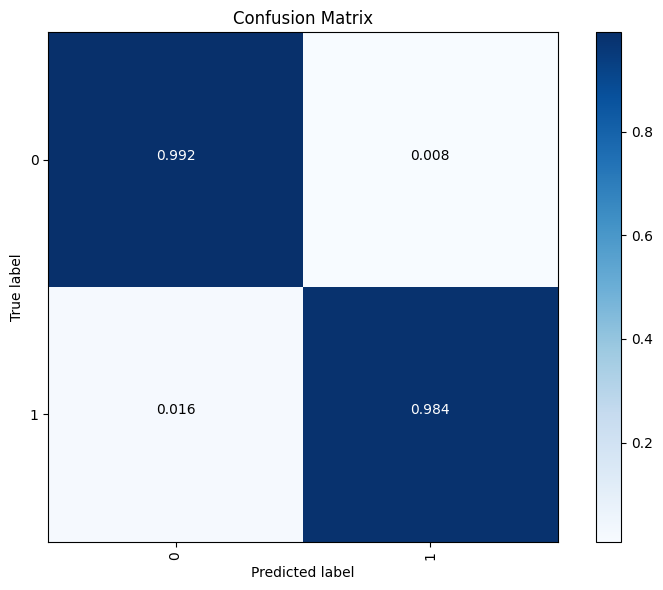


Classification report:

              precision    recall  f1-score   support

           0     0.9883    0.9916    0.9900      1193
           1     0.9883    0.9837    0.9860       857

    accuracy                         0.9883      2050
   macro avg     0.9883    0.9876    0.9880      2050
weighted avg     0.9883    0.9883    0.9883      2050



In [27]:
y_true = outputs.label_ids

y_pred = outputs.predictions.argmax(1)

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8), is_norm=True):
    """
    This function plots a confusion matrix.

    Parameters:
        cm (array-like): Confusion matrix as returned by sklearn.metrics.confusion_matrix.
        classes (list): List of class names, e.g., ['Class 0', 'Class 1'].
        title (str): Title for the plot.
        cmap (matplotlib colormap): Colormap for the plot.
    """
    plt.figure(figsize=figsize)
    
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    if is_norm:
        fmt = '.3f'
    else:
        fmt = '.0f'
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.tight_layout()
    plt.show()

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

if len(labels_list) <= 120:
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plot_confusion_matrix(cm, labels_list, figsize=(8, 6))

print()
print("Classification report:")
print()
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))

# Saving the model and checking its performance with a sample input

In [28]:
trainer.save_model()

In [29]:
tokenizer.save_vocabulary(save_directory=f"./{output_dir}")

('./sms-spam-detection-distilbert/vocab.txt',)

In [30]:
pipe = pipeline("text-classification", output_dir, tokenizer=BERT_MODEL)
sample_title = '''Elon Musk buys Twitter, and so can you'''
pipe(sample_title, top_k=10)

[{'label': '0', 'score': 0.9979867935180664},
 {'label': '1', 'score': 0.002013192279264331}]

In [34]:
%%time
df = pd.read_csv("/kaggle/input/iswpa-dataset/IWSPA-AP-Parsed.csv", encoding='latin-1')

item0 = df.shape[0]  
df = df.drop_duplicates()  
item1 = df.shape[0]  
print(f"There are {item0-item1} duplicates found in the dataset") 

df = df.rename(columns={'is_phishing': 'label', 'email_body': 'title'}) 

df = df[['label', 'title']]  
df['label'] = df['label'].astype('str')


df = df[~df['title'].isnull()] 
df = df[~df['label'].isnull()] 

print(df.shape) 
df.sample(5).T  

There are 1019 duplicates found in the dataset
(9275, 2)
CPU times: user 225 ms, sys: 24 ms, total: 249 ms
Wall time: 453 ms


,1384,5288,5840,7103,1073
label,0,0,0,0,0
title,Finance Guest Account (GUEST)'s trip approval ...,"ST. 1st Class Herring, Its not a problem, I ca...","""Thanks"" Ben for this, hi all and happy new ye...",fatto Da: Lucia Rana [mailto:l.rana@hackingtea...,To be automatically unsubscribed from this lis...


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9275 entries, 0 to 10295
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   9275 non-null   object
 1   title   9275 non-null   object
dtypes: object(2)
memory usage: 217.4+ KB


In [36]:
dataset = Dataset.from_pandas(df)

In [37]:
ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list)

def map_label2id(example):
    example['label'] = ClassLabels.str2int(example['label'])
    return example

dataset = dataset.map(map_label2id, batched=True)

dataset = dataset.cast_column('label', ClassLabels)

dataset = dataset.train_test_split(test_size=1, shuffle=True) # , stratify_by_column="label"

df_train = dataset['train']

df_test = dataset['test']

Map:   0%|          | 0/9275 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/9275 [00:00<?, ? examples/s]

In [38]:

tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL, use_fast=True, low_cpu_mem_usage=False)

In [39]:

def preprocess_function(examples):
   
    return tokenizer(examples["title"], truncation=True)


df_train = df_train.map(preprocess_function, batched=True)
df_test = df_test.map(preprocess_function, batched=True)

Map:   0%|          | 0/9274 [00:00<?, ? examples/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

In [40]:
df_train = df_train.remove_columns(['title'])

df_test = df_test.remove_columns(['title'])

In [41]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [42]:
tokenizer.decode(df_train[0]['input_ids'])

'[CLS] Alessandro Scarafile updated a event in the 00. TENTATIVE calendar Jan 2013, 2015 Until Jan 2114, 2015 Support Morocco ( ALFAHAD ) Client needs help for firewall configuration and system check. Refer to ticket YMN - 265 - 89975. You are receiving this notification because you are watching the following : 00. TENTATIVE Sent by Atlassian Confluence 5. 6. 3, the Enterprise Wiki [SEP]'

In [43]:
outputs = trainer.predict(df_train)

print(outputs.metrics)

{'test_loss': 1.0493415594100952, 'test_accuracy': 0.7524261375889584, 'test_runtime': 88.0566, 'test_samples_per_second': 105.319, 'test_steps_per_second': 1.647}


Accuracy: 0.7524
F1 Score: 0.6091


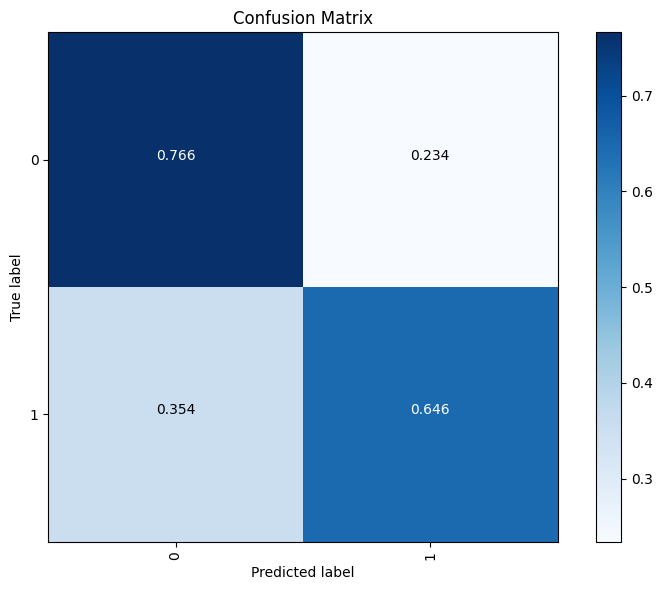


Classification report:

              precision    recall  f1-score   support

           0     0.9441    0.7661    0.8458      8220
           1     0.2615    0.6461    0.3723      1054

    accuracy                         0.7524      9274
   macro avg     0.6028    0.7061    0.6091      9274
weighted avg     0.8665    0.7524    0.7920      9274



In [44]:
y_true = outputs.label_ids

y_pred = outputs.predictions.argmax(1)

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8), is_norm=True):
   
    # Create a figure with a specified size
    plt.figure(figsize=figsize)
    
    
    # Display the confusion matrix as an image with a colormap
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    # Define tick marks and labels for the classes on the axes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    if is_norm:
        fmt = '.3f'
    else:
        fmt = '.0f'
    # Add text annotations to the plot indicating the values in the cells
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    # Label the axes
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Ensure the plot layout is tight
    plt.tight_layout()
    # Display the plot
    plt.show()

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

# Display accuracy and F1 score
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Get the confusion matrix if there are a relatively small number of labels
if len(labels_list) <= 120:
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    # Plot the confusion matrix using the defined function
    plot_confusion_matrix(cm, labels_list, figsize=(8, 6))

# Finally, display classification report
print()
print("Classification report:")
print()
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))